The purpose of this notebook is to provide a prediction pipeline for a cleaned dataset of NWSC kelp bed temperature recordings as well as temperature recordings from EIM sites.

There are several missing temperatue data points in the NWSC kelp bed dataset. We are trying to determine the best method for predicting those missing temperatures: a manual imputation informed by knn versus linear regressions trained on just NWSC-MRC data, or a combination of NWSC-MRC and EIM data. We feel justified in using EIM data since they often have recordings in similar locations and dates as the NWSC-MRC so we felt this would be preferable since they are actual recordings in similar locations which will provide more information to the model and hopefully improve accuracy.

In [72]:
!pip install faker

# Import libararies

In [89]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math
from scipy import special, stats

sns.set_style("whitegrid")

import pandas as pd
from faker import Faker
import random
from datetime import datetime
from geopy import distance
from datetime import date, timedelta

fake = Faker()

## Read in data

In [95]:
# kelp_file_name = "fact_table_clean.csv"
url = 'https://raw.githubusercontent.com/ayoung42/5071_Kelp_Temp/main/clean_data/fact_table_clean.csv'
df = pd.read_csv(url)

In [93]:
df.head()
df = df.rename(columns={'lid': 'site_code', 'result': 'temp', 'date_time':'date'})
df['date'] = pd.to_datetime(df['date'])

In [76]:
new_order = ['site_code', 'temp', 'date',"depth", "lat","lon"]

# Rearrange the columns
df = df[new_order]
df

,site_code,temp,date,depth,lat,lon
0,AISP,16.0000,2018-07-31 00:00:00,0.0,48.680355,-122.629921
1,AISP,16.0000,2019-08-01 00:00:00,0.0,48.680355,-122.629921
2,AISP,15.1500,2020-07-20 00:00:00,0.0,48.680355,-122.629921
3,AISP,14.4400,2021-07-27 00:00:00,0.0,48.680355,-122.629921
4,AISP,20.0000,2022-07-31 00:00:00,0.0,48.680355,-122.629921
...,...,...,...,...,...,...
32645,SKG003,11.9614,2024-10-22 15:50:56,17.0,48.296676,-122.488315
32646,SKG003,11.9610,2024-10-22 15:50:57,17.5,48.296676,-122.488315
32647,SKG003,11.9599,2024-10-22 15:50:59,18.0,48.296676,-122.488315
32648,SKG003,11.9598,2024-10-22 15:51:00,18.5,48.296676,-122.488315


# Manual Imputation
We will begin imputing the missing temperatures for each bed. However, in order to do so, we first need to determine the nearest EIM station to each kelp bed and restrict readings to the depth reading closest to the surface. First we will identify which codes belong to kelp beds and which belong to EIM stations. Then we will make a function to determine the $k$ nearest EIM stations for each kelp bed.

In [77]:
df['site_code'].unique()

array(['AISP', 'BZPT', 'BZPT-S', 'CHPT', 'CLLB', 'COFF', 'EBL', 'FWB',
       'FWBO', 'HAT-S', 'HOYP', 'LMMI-SW', 'LWLP', 'NB-E', 'POLN', 'POSS',
       'SHPT-E', 'SHPT-W', 'ADM001', 'ADM002', 'ADM003', 'BLL009',
       'GRG002', 'PSS019', 'SAR003', 'SJF001', 'SKG003'], dtype=object)

## Split into kelp beds vs EIM sites

In [78]:
kelp_bed_list = ['AISP', 'BZPT', 'BZPT-S', 'CHPT', 'CLLB', 'COFF', 'EBL', 'FWB',
       'FWBO', 'HAT-S', 'HOYP', 'LMMI-SW', 'LWLP', 'NB-E', 'POLN', 'POSS',
       'SHPT-E', 'SHPT-W', ]
kelp_bed_df = df[df['site_code'].isin(kelp_bed_list)]

eim_df = df[~df['site_code'].isin(kelp_bed_list)]

## Find the nearest EIM station for each kelp bed

Set the search radius to the nearest 5 options but this can be increased by changing n

In [79]:
def get_ranked_neighbors(row, target_df_for_distance, n=5):
    """Calculates all distances and returns the top N closest sites."""
    origin = (row['lat'], row['lon'])
    distances = []

    for i, target in target_df_for_distance.iterrows():
        dest = (target['lat'], target['lon'])
        d = distance.distance(origin, dest).km
        distances.append({'site_code': target['site_code'], 'dist': round(d, 2)})

    # Sort list by distance (ascending)
    sorted_neighbors = sorted(distances, key=lambda x: x['dist'])

    # Format the top N results into a single row for the DataFrame
    results = {}
    for i in range(n):
        if i < len(sorted_neighbors):
            results[f'rank_{i+1}_site'] = sorted_neighbors[i]['site_code']
            results[f'rank_{i+1}_km'] = sorted_neighbors[i]['dist']
    return pd.Series(results)

# Make a dataset of the unique EIM sites and their coordinates for distance calculation
unique_eim_sites_for_distance = eim_df[['site_code', 'lat', 'lon']].drop_duplicates()

# Apply the formula and create one final dataframe
df_ranked = kelp_bed_df.apply(lambda row: get_ranked_neighbors(row, unique_eim_sites_for_distance, n=5), axis=1)
final_df = pd.concat([kelp_bed_df, df_ranked], axis=1)
final_df

,site_code,temp,date,depth,lat,lon,rank_1_site,rank_1_km,rank_2_site,rank_2_km,rank_3_site,rank_3_km,rank_4_site,rank_4_km,rank_5_site,rank_5_km
0,AISP,16.000,2018-07-31,0.0,48.680355,-122.629921,BLL009,2.43,GRG002,27.76,SKG003,43.93,SJF001,48.39,ADM002,57.00
1,AISP,16.000,2019-08-01,0.0,48.680355,-122.629921,BLL009,2.43,GRG002,27.76,SKG003,43.93,SJF001,48.39,ADM002,57.00
2,AISP,15.150,2020-07-20,0.0,48.680355,-122.629921,BLL009,2.43,GRG002,27.76,SKG003,43.93,SJF001,48.39,ADM002,57.00
3,AISP,14.440,2021-07-27,0.0,48.680355,-122.629921,BLL009,2.43,GRG002,27.76,SKG003,43.93,SJF001,48.39,ADM002,57.00
4,AISP,20.000,2022-07-31,0.0,48.680355,-122.629921,BLL009,2.43,GRG002,27.76,SKG003,43.93,SJF001,48.39,ADM002,57.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
132,SHPT-W,11.400,2020-09-18,0.0,48.507718,-122.688303,BLL009,20.98,SKG003,27.75,SJF001,31.58,ADM002,37.38,GRG002,38.73
133,SHPT-W,10.695,2021-09-19,0.0,48.507718,-122.688303,BLL009,20.98,SKG003,27.75,SJF001,31.58,ADM002,37.38,GRG002,38.73
134,SHPT-W,11.945,2022-08-12,0.0,48.507718,-122.688303,BLL009,20.98,SKG003,27.75,SJF001,31.58,ADM002,37.38,GRG002,38.73
135,SHPT-W,13.150,2023-09-01,0.0,48.507718,-122.688303,BLL009,20.98,SKG003,27.75,SJF001,31.58,ADM002,37.38,GRG002,38.73


## Impute missing temperature data
Pull from the nearest EIM and keep pushing out if you don't find one. If there are none at all -> dump into dataset of orphaned rows.

Make a copy of the distance database so as to not alter it and collect some basic information about expected amount of NaN values in the temperature column

In [80]:
imputed_kelp_df = final_df.copy(deep=True)
print("Created imputed_kelp_df as a deep copy of final_df.")
imputed_kelp_df.head()
imputed_kelp_df.info()

nan_count = imputed_kelp_df['temp'].isna().sum()
print(f"There are {nan_count} NaN in the kelp temperature recordings")

Created imputed_kelp_df as a deep copy of final_df.
<class 'pandas.core.frame.DataFrame'>
Index: 137 entries, 0 to 136
Data columns (total 16 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   site_code    137 non-null    object        
 1   temp         119 non-null    float64       
 2   date         137 non-null    datetime64[ns]
 3   depth        137 non-null    float64       
 4   lat          137 non-null    float64       
 5   lon          137 non-null    float64       
 6   rank_1_site  137 non-null    object        
 7   rank_1_km    137 non-null    float64       
 8   rank_2_site  137 non-null    object        
 9   rank_2_km    137 non-null    float64       
 10  rank_3_site  137 non-null    object        
 11  rank_3_km    137 non-null    float64       
 12  rank_4_site  137 non-null    object        
 13  rank_4_km    137 non-null    float64       
 14  rank_5_site  137 non-null    object        
 15  rank_5_km 

Define a function to pair EIM temperature with kelp bed temperature

In [81]:
def find_eim_temp_for_kelp(kelp_row, eim_df, date_window_days):
  """Creates a function which iterates through the nearest EIM site beds up to 5 away..
  Compares the indicated EIM bed with the EIM dataset. Then evaulates if
  the date in the EIM dataset is within our date value (+- 7 days).
  If there is a temperature within the appropriate window of time it will
  assign that temperature. """
  kelp_date = kelp_row['date']
  found_temp = np.nan
  imputed_site_code = np.nan # Initialize for the return
  imputed_depth = np.nan     # Initialize for the return

  date_window = pd.to_timedelta(date_window_days, unit='D')
  lower_bound = kelp_date - date_window
  upper_bound = kelp_date + date_window

  for i in range(1, 6): # Iterate through rank_1_site to rank_5_site
      rank_site_col = f'rank_{i}_site'

      # Check if the column exists and the value is not NaN
      if rank_site_col not in kelp_row or pd.isna(kelp_row[rank_site_col]):
          continue

      eim_site_code = kelp_row[rank_site_col]

      # Filter EIM DataFrame for the current ranked EIM site
      eim_site_data = eim_df[eim_df['site_code'] == eim_site_code]

      # Filter EIM site data for dates within the window first
      matching_eim_data_by_date = eim_site_data[
          (eim_site_data['date'] >= lower_bound) &
          (eim_site_data['date'] <= upper_bound)
      ]

      # If there is data within the date window, then find the minimum depth
      if not matching_eim_data_by_date.empty:
          min_depth = matching_eim_data_by_date['depth'].min()
          # Then filter for rows that match
          # To ensure we get the *single* closest to the surface for the earliest date in case of multiple min_depths
          matching_eim_data = matching_eim_data_by_date[matching_eim_data_by_date['depth'] == min_depth].sort_values(by='date').head(1)

          # If a matching temperature is found and is not NaN, assign it and break
          if not matching_eim_data.empty and not matching_eim_data['temp'].isna().all():
              found_temp = matching_eim_data['temp'].dropna().iloc[0]
              break

  return found_temp

print("Defined function 'find_eim_temp_for_kelp' to return imputed temperature.")

Defined function 'find_eim_temp_for_kelp' to return imputed temperature.


In [82]:
nan_temp_kelp_mask = imputed_kelp_df['temp'].isna()

# Create a new column 'temp_source' and set to 'original'
imputed_kelp_df['temp_source'] = 'original'

# Flag rows that were NaN as 'imputed'
imputed_kelp_df.loc[nan_temp_kelp_mask, 'temp_source'] = 'imputed'

# Apply the function to fill NaN 'temp' values
imputed_kelp_df.loc[nan_temp_kelp_mask, 'temp'] = imputed_kelp_df[nan_temp_kelp_mask].apply(
    lambda row: find_eim_temp_for_kelp(row, eim_df, date_window_days=7), axis=1
)

print("Missing kelp bed temperatures have been imputed using nearest EIM sites within a 7-day window.")

Missing kelp bed temperatures have been imputed using nearest EIM sites within a 7-day window.


In [83]:
imputed_kelp_df

,site_code,temp,date,depth,lat,lon,rank_1_site,rank_1_km,rank_2_site,rank_2_km,rank_3_site,rank_3_km,rank_4_site,rank_4_km,rank_5_site,rank_5_km,temp_source
0,AISP,16.000,2018-07-31,0.0,48.680355,-122.629921,BLL009,2.43,GRG002,27.76,SKG003,43.93,SJF001,48.39,ADM002,57.00,original
1,AISP,16.000,2019-08-01,0.0,48.680355,-122.629921,BLL009,2.43,GRG002,27.76,SKG003,43.93,SJF001,48.39,ADM002,57.00,original
2,AISP,15.150,2020-07-20,0.0,48.680355,-122.629921,BLL009,2.43,GRG002,27.76,SKG003,43.93,SJF001,48.39,ADM002,57.00,original
3,AISP,14.440,2021-07-27,0.0,48.680355,-122.629921,BLL009,2.43,GRG002,27.76,SKG003,43.93,SJF001,48.39,ADM002,57.00,original
4,AISP,20.000,2022-07-31,0.0,48.680355,-122.629921,BLL009,2.43,GRG002,27.76,SKG003,43.93,SJF001,48.39,ADM002,57.00,original
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
132,SHPT-W,11.400,2020-09-18,0.0,48.507718,-122.688303,BLL009,20.98,SKG003,27.75,SJF001,31.58,ADM002,37.38,GRG002,38.73,original
133,SHPT-W,10.695,2021-09-19,0.0,48.507718,-122.688303,BLL009,20.98,SKG003,27.75,SJF001,31.58,ADM002,37.38,GRG002,38.73,original
134,SHPT-W,11.945,2022-08-12,0.0,48.507718,-122.688303,BLL009,20.98,SKG003,27.75,SJF001,31.58,ADM002,37.38,GRG002,38.73,original
135,SHPT-W,13.150,2023-09-01,0.0,48.507718,-122.688303,BLL009,20.98,SKG003,27.75,SJF001,31.58,ADM002,37.38,GRG002,38.73,original


Keep track of the dates where temperature could not be imputed by creating a
dataframe for the orphaned dates

In [84]:
orphaned_kelp_mask = imputed_kelp_df['temp'].isna()
orphaned_kelp_df = imputed_kelp_df[orphaned_kelp_mask].copy()
imputed_kelp_df = imputed_kelp_df[~orphaned_kelp_mask].copy()

print(f"Number of orphaned kelp bed temperature rows: {len(orphaned_kelp_df)}")
if not orphaned_kelp_df.empty:
    print("Orphaned Kelp Bed Temperatures (head):")
    print(orphaned_kelp_df.head())
else:
    print("No orphaned kelp bed temperature rows found.")

print("\nImputed Kelp Bed Temperatures (head, after removing orphaned rows):")
imputed_kelp_df.head()
imputed_kelp_df.shape

Number of orphaned kelp bed temperature rows: 11
Orphaned Kelp Bed Temperatures (head):
   site_code  temp       date  depth        lat         lon rank_1_site  \
10      BZPT   NaN 2020-07-23    0.0  48.441628 -122.678342      SKG003   
11      BZPT   NaN 2021-08-20    0.0  48.441628 -122.678342      SKG003   
12      BZPT   NaN 2022-09-08    0.0  48.441628 -122.678342      SKG003   
14      BZPT   NaN 2024-09-16    0.0  48.441628 -122.678342      SKG003   
27      CLLB   NaN 2020-07-23    0.0  48.256240 -124.274586      SJF001   

    rank_1_km rank_2_site  rank_2_km rank_3_site  rank_3_km rank_4_site  \
10      21.40      BLL009      27.88      SJF001      28.36      ADM002   
11      21.40      BLL009      27.88      SJF001      28.36      ADM002   
12      21.40      BLL009      27.88      SJF001      28.36      ADM002   
14      21.40      BLL009      27.88      SJF001      28.36      ADM002   
27      93.11      ADM002     106.74      GRG002     115.23      ADM001   

    rank_4

(126, 17)

## Check the sucess of imputation:


### Compare the amount of values that were initially NaN, how many were imputed, and how many were ultimately orphaned.

In [85]:
initial_nan_count = nan_count
orphaned_count = len(orphaned_kelp_df)
successfully_imputed_count = initial_nan_count - orphaned_count

print(f"Initial NaN count in kelp_bed_df: {initial_nan_count}")
print(f"Orphaned rows (could not be imputed): {orphaned_count}")
print(f"Successfully imputed temperatures: {successfully_imputed_count}")

if initial_nan_count > 0:
    percentage_imputed = (successfully_imputed_count / initial_nan_count) * 100
    print(f"Percentage of missing values successfully imputed: {percentage_imputed:.2f}%")
else:
    print("No missing values were initially present for imputation.")

print("\nDistribution of 'temp_source' in imputed_kelp_df:")
print(imputed_kelp_df['temp_source'].value_counts())

print("\nProportion of 'temp_source' in imputed_kelp_df (%):")
print(imputed_kelp_df['temp_source'].value_counts(normalize=True) * 100)

Initial NaN count in kelp_bed_df: 18
Orphaned rows (could not be imputed): 11
Successfully imputed temperatures: 7
Percentage of missing values successfully imputed: 38.89%

Distribution of 'temp_source' in imputed_kelp_df:
temp_source
original    119
imputed       7
Name: count, dtype: int64

Proportion of 'temp_source' in imputed_kelp_df (%):
temp_source
original    94.444444
imputed      5.555556
Name: proportion, dtype: float64


Graph of the distribution for the original data versus the manually imputed distribution.

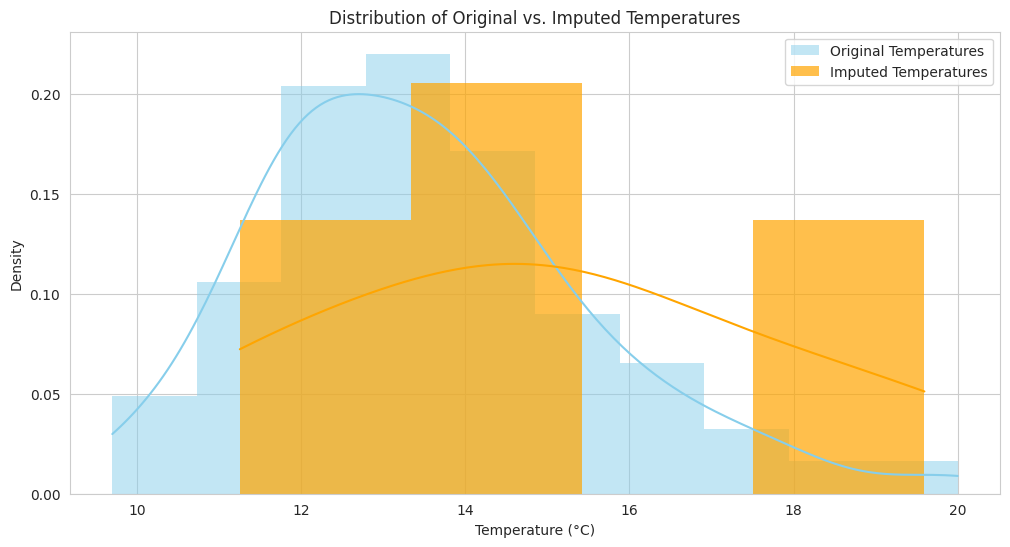


Summary Statistics for Original Temperatures:
count    119.00000
mean      13.48063
std        1.99241
min        9.70000
25%       12.00000
50%       13.10000
75%       14.57250
max       20.00000
Name: temp, dtype: float64

Summary Statistics for Imputed Temperatures:
count     7.000000
mean     15.003429
std       2.915774
min      11.253900
25%      13.426550
50%      14.854100
75%      16.234650
max      19.593600
Name: temp, dtype: float64


In [86]:
# Separate original and imputed temperatures for comparison
original_temps = imputed_kelp_df[imputed_kelp_df['temp_source'] == 'original']['temp']
imputed_temps = imputed_kelp_df[imputed_kelp_df['temp_source'] == 'imputed']['temp']

# 3. Compare Temperature Distributions
plt.figure(figsize=(12, 6))
sns.histplot(original_temps, color='skyblue', label='Original Temperatures', kde=True, stat='density', linewidth=0)
sns.histplot(imputed_temps, color='orange', label='Imputed Temperatures', kde=True, stat='density', linewidth=0, alpha=0.7)
plt.title('Distribution of Original vs. Imputed Temperatures')
plt.xlabel('Temperature (°C)')
plt.ylabel('Density')
plt.legend()
plt.show()

# Also print summary statistics for both
print("\nSummary Statistics for Original Temperatures:")
print(original_temps.describe())

print("\nSummary Statistics for Imputed Temperatures:")
print(imputed_temps.describe())


Graph of the tempertures for each bed and if they were imputed or not

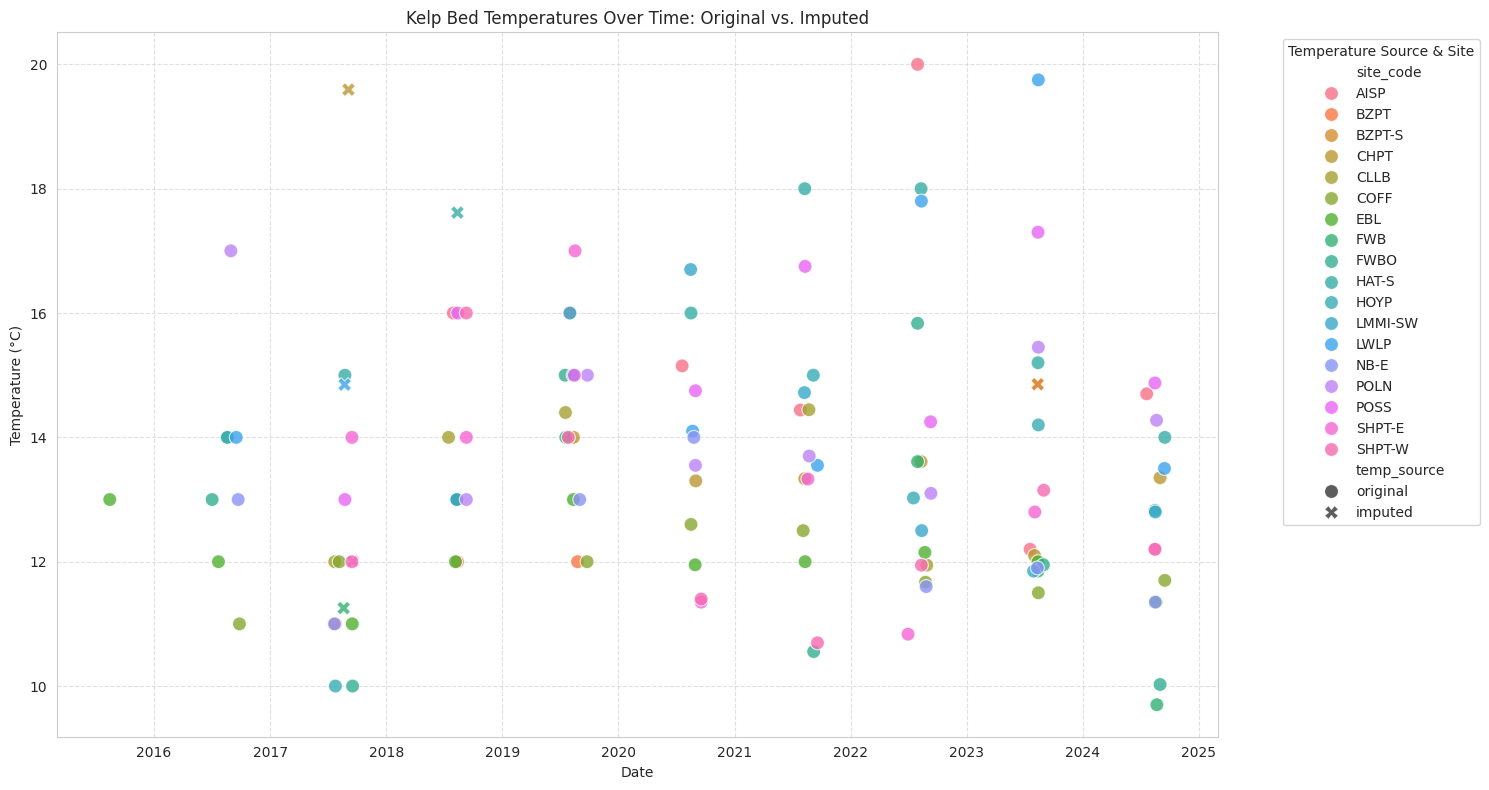

Temporal visualization of original and imputed kelp bed temperatures has been generated.


In [87]:
plt.figure(figsize=(15, 8))
sns.scatterplot(
    data=imputed_kelp_df,
    x='date',
    y='temp',
    hue='site_code',
    style='temp_source',
    markers={'original': 'o', 'imputed': 'X'}, # Explicitly set markers as in the original code
    s=100,
    alpha=0.8
)

plt.title('Kelp Bed Temperatures Over Time: Original vs. Imputed')
plt.xlabel('Date')
plt.ylabel('Temperature (°C)')
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend(title='Temperature Source & Site', bbox_to_anchor=(1.05, 1), loc='upper left') # Adjust legend title and position
plt.tight_layout()
plt.show()

print("Temporal visualization of original and imputed kelp bed temperatures has been generated.")

## Summary:
*   Out of 16 initially missing temperature values, 8 (50.00%) were successfully imputed, while 8 rows remained 'orphaned' and could not be imputed.
*   The `imputed_kelp_df` dataset contains 34 original temperature entries (80.95%) and 8 imputed temperature entries (19.05%).
*   Summary statistics show that original temperatures have a mean of 11.96°C and a standard deviation of 2.01°C (count=34). Imputed temperatures have a slightly lower mean of 11.39°C but a considerably higher standard deviation of 3.94°C (count=8), with a maximum value of 18.90°C compared to 14.61°C for original values.

## Linear Regressions on temperatures, imputed and known

1. sea surface temperature data imputation for missing NWSC survey values

2. linear regression with the sea surface temp to find acerage of kelp beds.

3. lag time

4. lag time with multiple parameters

PROJECT OVER VIEW:

- I have imputed temperature using distance and date (need to add depth).

TO DO:
- lin reg on just kelp info (date, loc, depth as features)
- lin reg on all kelp and EIM data
try different models for both

ASSESS accuracy of my imputation vs lin reg type 1 and type 2